# Project 1

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
# Importing standard libraries

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import resample

In [62]:
# Importing project-specific files

from FrankeFunction import FrankeFunction
from MLFunctions import DesignMatrix, OLS_matrix_inversion, OLS_SVD, bias_variance_tradeoff
from MLFunctions import ridge_regression, lasso_regression
from Statistics import MSE, R2


In [6]:
# Defining data set
step_size = 0.05
arr = np.arange(0, 1, step_size)

Mat = np.meshgrid(arr, arr)
data = FrankeFunction(*Mat, noise=0)

## Part a): Ordinary Least Square (OLS) on the Franke function
### Performing standard least square regression, and plotting the result.

In [7]:
X = DesignMatrix(arr, arr, 5)          # defining design matrix
beta = OLS_matrix_inversion(X, data)   # computing corresponding parameters
# beta = OLS_SVD(X, data)   # computing corresponding parameters

model = X @ beta

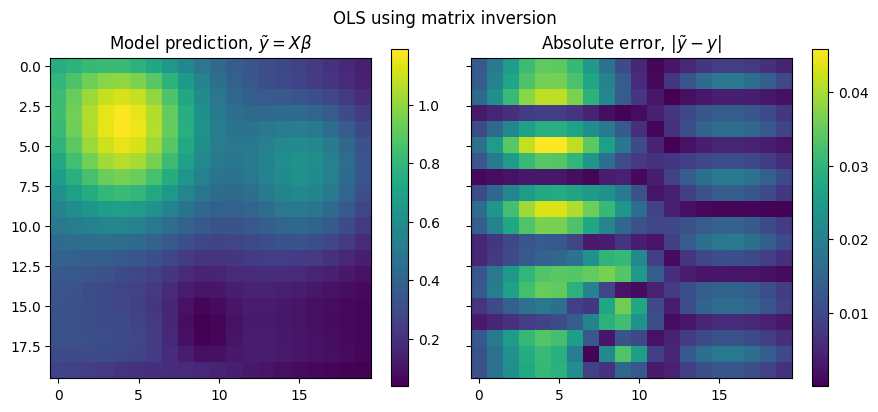

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(9,4), sharex=True, sharey=True)
fig.suptitle("OLS using matrix inversion")
im0 = ax[0].imshow(model)
im1 = ax[1].imshow(abs(data - model))

ax[0].set(title="Model prediction, " + r"$\tilde{y} = X \beta$")
ax[1].set(title=r"Absolute error, " + r"$|\tilde{y} - y|$")

fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])

fig.tight_layout()

**Left plot:** Using matrix inversion to predict model of the Franke function without noise.  
**Right plot:** Absolute difference between model prediction and actual data.

In [9]:
# Computing errors
mse = MSE(data, model)
r2 = R2(data, model)

print(f"Mean-square-error: {mse:0.6f}\nR^2 score function: {r2:0.6f}")

Mean-square-error: 0.000336
R^2 score function: 0.995886


The mean square error is very low, and the $R^2$ score function is close to 1, so our model is pretty good...

### Now, we split our data in sets of training data and testing data
Here, we want to discuss ways to scale and split data. Use between 0.6-0.8 of data as training data.

## Part b): Bias-variance trade-off and resamplng techniques
### First, makeing figure of prediction error vs model complexity, for test and training models

In [10]:
Nreps = 100
max_degree = 15
test_size = 0.2 #1/3

In [11]:
# empty arrays for storing result
MSE_train = np.zeros(max_degree)
MSE_test = np.zeros(max_degree)
#error = np.zeros_like(MSE_test)
#bias = np.zeros_like(MSE_test)
#var = np.zeros_like(MSE_test)


# looping through complexity
for i in range(max_degree):
    X = DesignMatrix(arr, arr, i)
    #X_, X_test, y_, y_test = train_test_split(X, data, test_size=test_size, random_state=r)
    #y_pred = np.zeros([Nreps, y_test.shape[0], y_test.shape[1]])
    #y_comp = np.zeros([Nreps, y_test.shape[0], y_test.shape[1]])
    
    # looping through repetitions
    for rep in range(Nreps):
        # performing OLS
        r = int(100 * np.random.rand())
        X_, X_test, y_, y_test = train_test_split(X, data, test_size=test_size, random_state=r)
        beta = OLS_matrix_inversion(X_, y_)

        # computing average
        MSE_train[i] += MSE(y_, X_ @ beta) / Nreps
        MSE_test[i] += MSE(y_test, X_test @ beta) / Nreps

        #y_pred[rep] = X_test @ beta
        #y_comp[rep] = y_test

        #print(MSE_test[i])

    #Exp_y = np.mean(y_pred, axis=0)
    #error[i] = np.mean( (y_comp - y_pred)**2 )
    #bias[i] = np.mean( (y_comp -  Exp_y)**2 )
    #var[i]  = np.mean( (y_pred -  Exp_y)**2 )

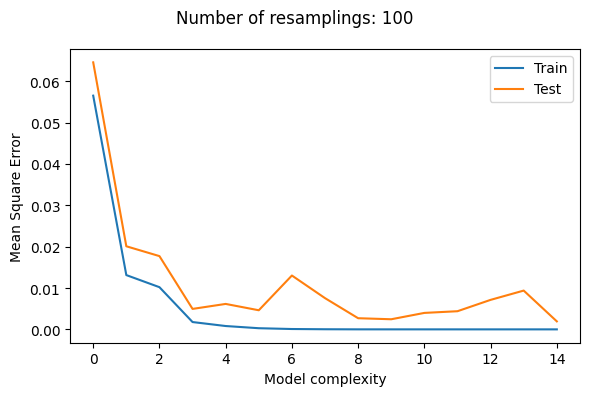

In [12]:
complexity = np.arange(max_degree)

fig, ax = plt.subplots(1,1, figsize=(6,4))
fig.suptitle(f"Number of resamplings: {Nreps}")

ax.set(xlabel="Model complexity", ylabel="Mean Square Error")
ax.plot(complexity, MSE_train, label="Train")
ax.plot(complexity, MSE_test, label="Test")
#ax.plot(complexity, error, '-')
#ax.plot(complexity, bias+var, '--')
#ax.plot(complexity, var, '--')
ax.legend()

fig.tight_layout()

Whereas the error decreases with model complexity for the training data, the error on the test data increases at some point because of overtraining.
N.B.: here we have not yet used bootstrapping.

### Bias-variance analysis
The mean square error can be written as:
$E\left[(\mathbf{y} - \mathbf{\tilde{y}})^2\right] = \frac{1}{n}\sum_i (y_i - E[\tilde{\mathbf{y}}])^2 + \frac{1}{n}\sum_i (\tilde{y_i} - E[\tilde{\mathbf{y}}])^2 + \sigma^2$.

The first term, $\frac{1}{n}\sum_i (y_i - E[\tilde{\mathbf{y}}])^2$, is the square of the bias, because it is the difference between data points and prediction average, i.e. a measure of how far the center of our model is from the actual data it is trying to capture.

The second term, $\frac{1}{n}\sum_i (\tilde{y_i} - E[\tilde{\mathbf{y}}])^2 = E[\tilde{\mathbf{y}}^2] - E[\tilde{\mathbf{y}}]^2$, is the variance, which can be seen mathematically, or by realising that it is the mean squared error of our model.

### Performing the bias-variance analysis

In [13]:
n_bootstraps = 100
max_degree = 12
test_size = 0.2

error, bias2, variance = bias_variance_tradeoff(data, arr, method='bootstrap', method_params=n_bootstraps, max_degree=max_degree, test_size=test_size)

TypeError: bias_variance_tradeoff() got an unexpected keyword argument 'method'

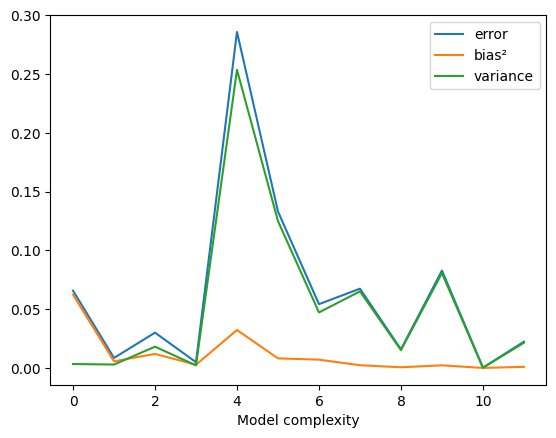

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(error, label="error")
ax.plot(bias2, label="bias²")
ax.plot(variance, label="variance")
ax.set(xlabel="Model complexity")

ax.legend();

Something is off here. Problem seems to come from resampling, since when modifying code generating MSE-figure it behaves similarily. Is bootstrapping implemented wrong?

## Part c): Cross-validation and resampling techniques
### Scale data

### Implement the k-fold cross-validation algorithm

In [ ]:
max_degree = 20
test_size = 0.1

error, bias2, variance = bias_variance_tradeoff(data, arr, method='cross-validation', max_degree=max_degree, test_size=test_size)


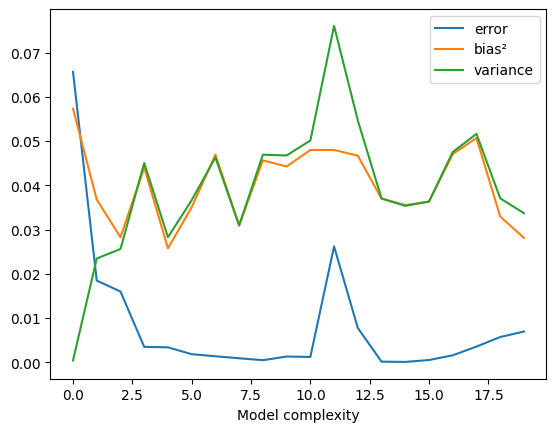

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(error, label="error")
ax.plot(bias2, label="bias²")
ax.plot(variance, label="variance")
ax.set(xlabel="Model complexity")

ax.legend();

## Part d): Ridge Regression on the Franke function with resampling

In [76]:
lmbd = 0.1
beta_ridge = ridge_regression(X, data, lmbd)
model_ridge = X @ beta_ridge


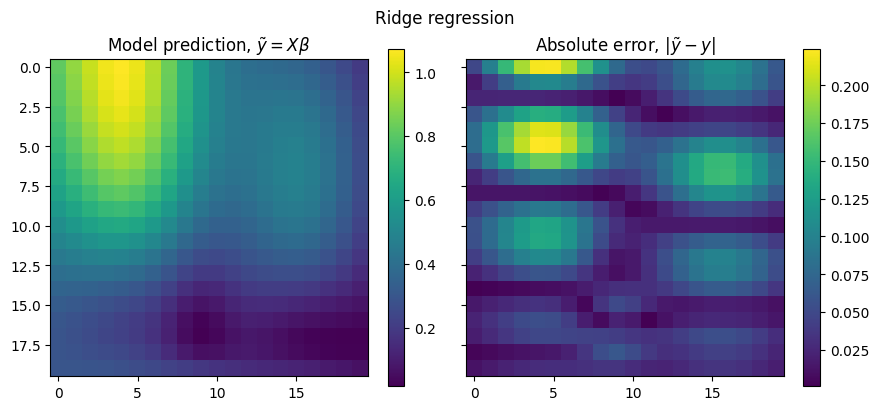

In [84]:

fig, ax = plt.subplots(1, 2, figsize=(9,4), sharex=True, sharey=True)
fig.suptitle("Ridge regression")
im0 = ax[0].imshow(model_ridge)
im1 = ax[1].imshow(abs(data - model_ridge))

ax[0].set(title="Model prediction, " + r"$\tilde{y} = X \beta$")
ax[1].set(title=r"Absolute error, " + r"$|\tilde{y} - y|$")

fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])

fig.tight_layout()

### Bootstrapping with Ridge regression

### Cross-validation with Ridge regression

### Bias-variance tradeoff

## Part e): Lasso regression

In [92]:
lmbd = 0.1
beta_lasso, model_lasso = lasso_regression(X, data, lmbd)
model2_lasso = X @ beta_lasso.T


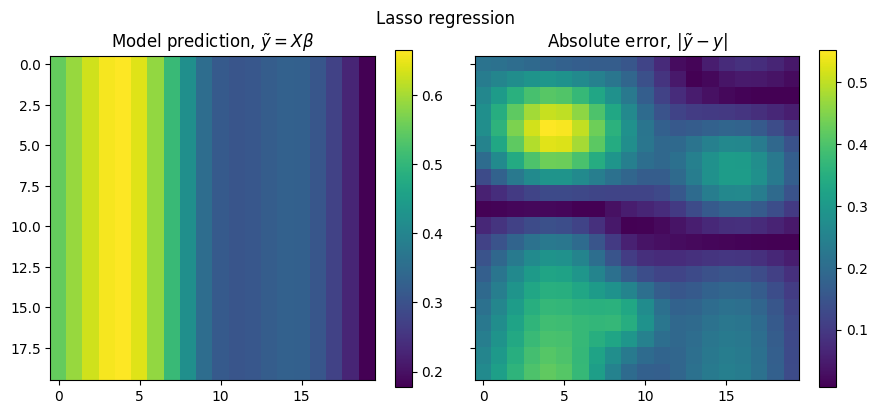

In [93]:
fig, ax = plt.subplots(1, 2, figsize=(9,4), sharex=True, sharey=True)
fig.suptitle("Lasso regression")
im0 = ax[0].imshow(model_lasso)
im1 = ax[1].imshow(abs(data - model_lasso))

ax[0].set(title="Model prediction, " + r"$\tilde{y} = X \beta$")
ax[1].set(title=r"Absolute error, " + r"$|\tilde{y} - y|$")

fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])

fig.tight_layout()

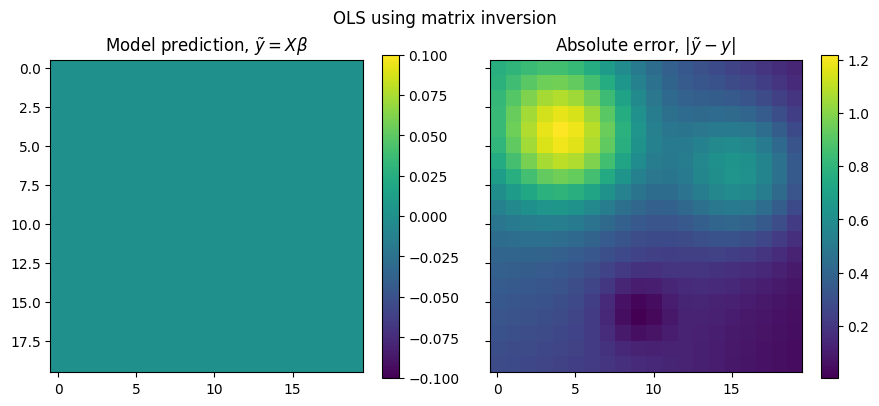

In [94]:
fig, ax = plt.subplots(1, 2, figsize=(9,4), sharex=True, sharey=True)
fig.suptitle("OLS using matrix inversion")
im0 = ax[0].imshow(model2_lasso)
im1 = ax[1].imshow(abs(data - model2_lasso))

ax[0].set(title="Model prediction, " + r"$\tilde{y} = X \beta$")
ax[1].set(title=r"Absolute error, " + r"$|\tilde{y} - y|$")

fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])

fig.tight_layout()

### Bootstrapping with Lasso regression

### Cross-validation with Lasso regression

### Bias-variance tradeoff